<a href="https://colab.research.google.com/github/Jaesu26/aifactory-water-demand-forecasting/blob/main/2022-12-08-%ED%96%89%EC%A0%95%EB%B0%8F%EC%A3%BC%EA%B1%B0%EC%A7%80%EC%97%AD-%EC%88%98%EB%8F%97%EB%AC%BC-%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2022 제2회 K-water AI 경진대회] 수돗물 수요예측 AI 알고리즘 개발

- [2022-Task 1] 혁신도시: 경상북도 김천시 율곡동

In [1]:
import platform

In [2]:
platform.platform()

'Linux-5.10.133+-x86_64-with-glibc2.27'

In [3]:
!cat /etc/issue.net

Ubuntu 18.04.6 LTS


In [4]:
!python --version

Python 3.8.15


In [1]:
!nvidia-smi

Thu Dec  8 13:25:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

런타임 유형: GPU

Linux-5.10.133+-x86_64-with-glibc2.27

Ubuntu 18.04.6 LTS

Python 3.8.15

GPU: NVIDIA-SMI 460.32.03

Driver Version: 460.32.03

CUDA Version: 11.2

## 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import math
import os
import gc

import statsmodels.graphics.tsaplots as sgt

from typing import List, Optional, Tuple, Union
from numpy.typing import NDArray
from easydict import EasyDict

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [3]:
from google.colab import drive

drive.mount('/content/drive')  # 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [4]:
%cd  /content/drive/MyDrive/Colab Notebooks/행정및주거지역-수돗물-수요예측

/content/drive/MyDrive/Colab Notebooks/행정및주거지역-수돗물-수요예측


- 데이터 불러오기

In [5]:
train_path = './data/data_tr_city.csv'
test_path = './data/data_ts_city.csv'
submission_path = './data/sample_city.csv'

In [71]:
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [72]:
# 변수 이름을 영문으로 변경
df = df.rename(columns={'구미 혁신도시배수지 유출유량 적산차':'flow'})
test = test.rename(columns={'구미 혁신도시배수지 유출유량 적산차':'flow'})


# 날짜를 datetime 형식으로 변경
df['datetime'] = pd.to_datetime(df['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
submission['datetime'] = pd.to_datetime(submission['datetime'])

In [73]:
test2 = test.copy()

- 가중치 저장폴더

In [9]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

- 데이터 설명

`-` 유량: 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타냄 ($m^3/h$)

`-` 적산값: 1시간마다 측정한 값이 계속 누적 (i.g. $100 \xrightarrow{~+170~} 270 \xrightarrow{~+150~} 420 \xrightarrow{~+110~} 530$)  

`-` 적산차값: 적산의 매시간 차이를 계산 ($\approx$ 시간 단위 공급량,$\quad$ i.g. $\operatorname{NA},170, 150, 110$)

## 전처리

`-` 데이터는 항상 시간상의 순서대로 존재해야 한다

`-` 데이터에서 특정 시점의 적산차값이 결측치일 수도 있지만 특정 시점 자체가 누락되면 안된다 

`-` 그래프에 추세는 없어보인다

`-` 데이터에 결측치가 존재한다

`-` 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채워주자

`-` 이상치가 존재한다 (예컨대 음수 또는 매우 큰 양수)

`-` 로그 변환

`-` 후처리는 반올림

- 이상치와 결측치 처리

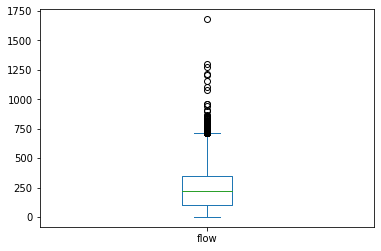

In [14]:
df.query('0 < flow < 2000').flow.plot.box()

`-` 1,000,000을 넘기는 매우 큰 값이 존재한다

`-` 또한, 음수값도 존재하는데 이들은 모두 -1,000,000보다 작다

`-` 위와 같은 경우는 계측기에 문제가 있는 것으로 보인다

`-` 0인 경우도 존재한는데 계측기의 오류 또는 모종의 이유로 물이 흐르지 않은 것으로 보인다 (i.g. 배수지 청소로 인해 단수)

`-` 이런 경우 적산차값만 사용해 예측하는 것은 불가능하므로 이상치로 처리하겠다  

`-` 한편, 큰 양수의 경우 이상치의 기준은 IQR을 고려하여 800으로 설정하겠다

`-` 이상치와 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 대체하겠다

In [10]:
def fillna(time_series: pd.Series, m: int = 24) -> pd.Series:
    """m 시점 앞의 값으로 결측치를 재귀적으로 채우고 데이터를 반환"""
    assert time_series.ndim == 1
    time_series = time_series.copy()  # 원본이 변하지 않도록 복제 
    na_idx = time_series[time_series.isnull()].index.values
    fill_idx = na_idx - m  # m 시점 앞의 값으로 결측치를 채운다
    fill_idx = np.where(fill_idx < 0, fill_idx + m, fill_idx)

    if not na_idx.size:                  # 결측치가 존재하지 않으면 원본을 반환
        return time_series
    if np.in1d(fill_idx, na_idx).all():  # m 시점 앞의 값이 결측치면 원본을 반환
        return time_series

    time_series[na_idx] = time_series[fill_idx]
    return fillna(time_series, m)

In [74]:
# 이상치는 결측치로 처리한다
tmp = df.flow[df.flow < 800].max()
df['flow'] = df['flow'].apply(lambda x: x if 0 < x <= tmp else np.nan)
test2['flow'] = test2['flow'].apply(lambda x: x if 0 < x <= tmp else np.nan)

In [75]:
# 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채운다 
df['flow'] = fillna(df['flow']).fillna(method='ffill').fillna(0)
test2['flow'] = fillna(test2['flow']).fillna(method='ffill').fillna(0)

## 시각화

In [13]:
sns.set_theme(style='white')

In [19]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).\
groupby('year').flow.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2017,8759.0,209.705511,145.661877,1.0,92.0,189.0,300.0,956.0
2018,8760.0,235.595179,156.254107,10.0,106.0,217.0,346.0,839.0
2019,8760.0,247.972441,165.519941,11.0,109.0,231.0,363.0,910.0
2020,8784.0,254.597728,168.770647,7.0,115.0,240.0,372.0,962.0


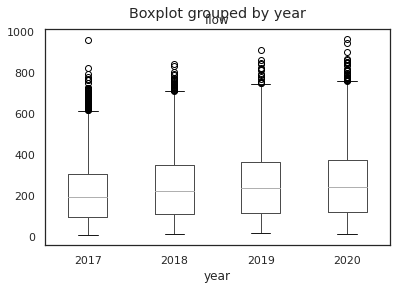

In [20]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).boxplot(column='flow', by='year', grid=False)

`-` 적산차의 경우 배수지 확장으로 인해 시간이 지날수록 평균과 분산이 커지고 있다

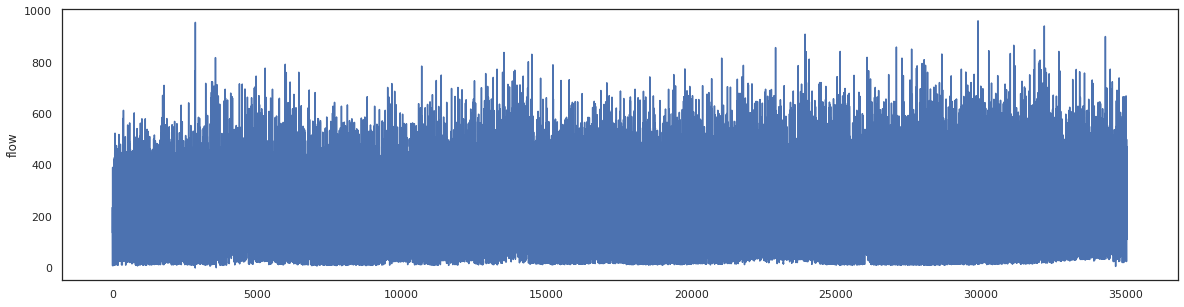

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=df['flow'], ax=ax)

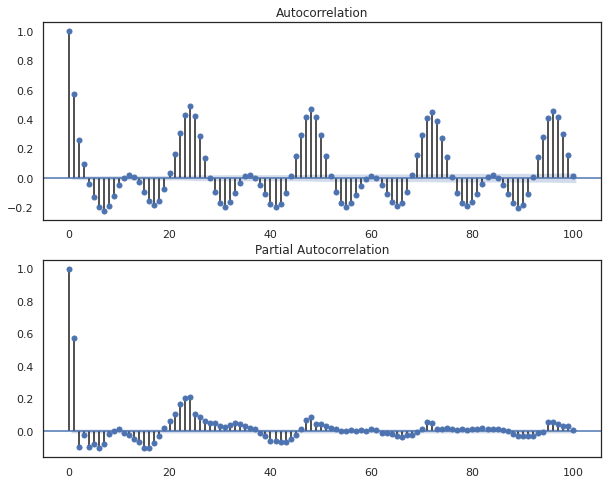

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sgt.plot_acf(df['flow'], lags = 100, ax=ax1);
sgt.plot_pacf(df['flow'], lags = 100, ax=ax2);

`-` 그래프에 2017년을 제외하면 추세는 존재하지 않고 강한 계절성이 존재한다

`-` ACF, PACF의 정의에 따라 0시점 차이는 의미가 없으므로 무시한다

`-` 계절성이 매우 강하다 (6시간, 18시간, 24시간, 1주, 1달, 1년 등)

`-` 신기한 것은 12시점(12시간)차이의 경우 자기상관이 존재하지 않는다

`-` 사이클(W 모양)이 대략 24시간 마다 반복되므로 최소 24시간 분량의 변수를 모델의 입력으로 사용해야 한다

- 추가 설명

`-`  hello 라는 단어를 생각해보자, 다음의 같은 사이클이 반복된다

`-` h $\to$ e, e $\to$ l, l $\to$ l, l $\to$ o, o $\to$ h 

`-` 만약 단어 하나만이 입력으로 주어진다면 l이 입력으로 들어왔을 때 다음에 오는 단어가 l인지 o인지 알 수 없다

`-` 하지만 연속된 단어 두개가 입력으로 주어진다면 다음에 올 단어를 예측할 수 있다

`-` 예컨대 ll 이면 o, lo 이면 h이다

`-` 이는 적산차를 예측하는 문제에서도 마찬가지이다

## 딥러닝 모델 학습

In [28]:
!git clone https://github.com/ts-kim/RevIN.git

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.autograd import Variable

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

from RevIN.RevIN import RevIN

- base score

In [38]:
m = 24
mean_absolute_error(df['flow'].values[m:], df['flow'].ewm(span=2).mean().values[:-m])

110.4960700967797

- 학습 방법

`-` private 데이터는 2022-01-01-00:00:00 부터 존재할 것이다

`-` public 데이터는 2021-12-17 23:00:00 까지 존재한다

`-` 2021-12-17 23:00:00 에서 337시간 뒤는 2022-01-01 00:00:00 이다

`-` 337시간 후의 적산차를 예측하는 모델을 만드는게 적합하지만 그러면 시간상의 차이가 많이 나서 성능이 떨어진다

`-` 따라서 1시간 후의 적산차를 예측하는 모델을 만들고 존재하지 않는 시각의 정보는 예측한 정보로 대체하여 사용하겠다

`-` 1시간 후의 적산차를 예측하기 위해 pacf 그래프에 근거해 24시간의 배수에 해당하는 분량을 사용하겠다

`-` 사이클을 포함하는(24시간 이상) 시계열 중 24시간 차이가 나는 데이터간의 직접적인 상관관계가 가장 크다

`-` 하나의 사이클을 포함하면서 과적합을 피하기 위해 24*n 시간 분량을 사용하겠다

- 전처리

In [15]:
def ts_train2supervised(
    ts: NDArray[np.float_], 
    window: int = 24,
    gap: int = 1, 
    step: int = 336
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X, y = [], []
    for t in range(len(ts) - (window+gap+step) + 2):
        X.append(ts[t:t+window])
        y.append(ts[t+window+gap-1 : t+window+gap+step-1])
    X, y = np.array(X), np.array(y)  
    return X, y

`-` 예측을 위해 train과 test를 병합 

In [16]:
def ts_test2supervised(
    ts: NDArray[np.float_], 
    window: int = 24
) -> NDArray[np.float_]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X = []
    for t in range(len(ts) - window + 1):
        X.append(ts[t:t+window])
    X = np.array(X)
    return X

- 난수 고정, gpu 설정

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

In [18]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

In [19]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {DEVICE}입니다')

현재 device는 cuda입니다


- 피쳐 스케일링

`-` 0 ~ 1 사이로 정규화

In [76]:
minmax_scaler = MinMaxScaler()
flow_scaled = minmax_scaler.fit_transform(df['flow'].values.reshape(-1, 1))
flow_scaled_test = minmax_scaler.transform(test2['flow'].values.reshape(-1, 1))

- 데이터 셋과 데이터 로더

In [21]:
class CustomDataset(Dataset):
    def __init__(self, X: NDArray[np.float_], y: Optional[NDArray[np.float_]] = None) -> None:
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor], Tensor]:
        X = torch.FloatTensor(self.X[idx])
        if self.y is not None:
            y = torch.FloatTensor(self.y[idx])
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

In [22]:
def get_dataloader(
    X: NDArray[np.float_], 
    y: Optional[NDArray[np.float_]] = None, 
    batch_size: int = 64, 
    shuffle: bool = True
) -> DataLoader:
    dataset = CustomDataset(X, y)    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

- early stopping

In [23]:
# ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
        'mae',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        folder_path: str = './weights', 
        model_name: str = '',
    ) -> None:
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  # 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.folder_path = folder_path    
        self.model_name = model_name
        self.reset_fold()  # for k-fold cross validation

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        # score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        # score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  # 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  # score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path) 
        self.valid_loss = valid_loss  # 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  # 이때의 valid metric score도 변경

    @property
    def path(self) -> str:
        return f'{self.folder_path}/{self.model_name}_best_{self.fold}.pt'

    def reset_fold(self) -> None:
        self.fold = 0

    def update_fold(self) -> None:
        self.fold += 1

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

- 손실 함수

In [24]:
loss_fn = nn.L1Loss()  # MAE

- 학습 및 검증

In [25]:
def train(
    model: nn.Module,
    dataloader: DataLoader, 
    device: torch.device,
    loss_fn: _Loss, 
    optimizer: Optimizer, 
    scaler: torch.cuda.amp.GradScaler,
    args: EasyDict,
    scheduler: Optional[_LRScheduler] = None
) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0
    model.to(device)
    model.train()

    for X, y in dataloader:  
        X, y = X.to(device), y.to(device) 
        with torch.cuda.amp.autocast():
            y_hat = model(X)
            loss = loss_fn(y_hat, y)  

        optimizer.zero_grad()  
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.max_norm)
        scaler.step(optimizer)
        scaler.update()
        train_loss += (loss.item() / len(dataloader)) 
  
    # 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()
        
    return model, train_loss

In [49]:
def evaluate(
    model: nn.Module, 
    dataloader: DataLoader, 
    device: torch.device,
    loss_fn: _Loss,
    args: EasyDict
) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 ACD f1 score를 반환"""
    valid_loss = 0.0
    y_list, yhat_list = np.array([]).reshape(0, args.num_classes), np.array([]).reshape(0, args.num_classes)
    model.to(device)
    model.eval()  

    with torch.no_grad():  
        for X, y in dataloader:  
            X, y = X.to(device), y.to(device) 
            with torch.cuda.amp.autocast():
                y_hat = model(X)
                loss = loss_fn(y_hat, y)
                  
            y = y.detach().cpu().numpy()  # y shape: (B, 336)
            y_hat = y_hat.detach().cpu().numpy()  # yhat shape: (B, 336)
            y_list = np.concatenate([y_list, minmax_scaler.inverse_transform(y)])
            yhat_list = np.concatenate([yhat_list, minmax_scaler.inverse_transform(y_hat)])
            valid_loss += (loss.item() / len(dataloader))

    valid_mae = mean_absolute_error(y_list, yhat_list)        
    return valid_loss, valid_mae

In [27]:
def kfold_cross_validate(
    model: nn.Module, 
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    loss_fn: _Loss, 
    early_stopping: EarlyStopping,
    device: torch.device,
    args: EasyDict 
) -> Tuple[nn.Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 검증 손실을 반환"""
    seed_everything(args.seed)   # 정확한 재현을 위함
    fold_valid_loss = []         # 폴드별 best 검증 손실
    fold_valid_mae = []          # 폴드별 best 검증 MAE
    fold_train_losses_per_epoch = [[] for _ in range(args.num_folds)]  # 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(args.num_folds)]  # 폴드별 1 에폭에 따른 검증 배치 손실
    early_stopping.reset_fold()  # 폴드 순서 0 번째로 초기화
    tscv = TimeSeriesSplit(n_splits=args.num_folds)     

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f'[{fold + 1} / {args.num_folds}] Fold Training......')

        # 메모리 절약
        clear_gpu()

        # 훈련 데이터와 검증 데이터로 분할
        X_train, y_train = X[train_idx], y[train_idx] 
        X_val, y_val =  X[val_idx], y[val_idx]

        # Dataloader
        train_dataloader = get_dataloader(X_train, y_train, args.bs)
        valid_dataloader = get_dataloader(X_val, y_val, args.bs, shuffle=False)

        # optimizer
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay) 

        # scheduler
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_gamma)

        # grad scalder
        scaler = torch.cuda.amp.GradScaler()

        # early stopping, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.update_fold()  
        
        # 폴드마다 모델 학습
        for epoch in tqdm(range(1, args.num_epochs+1)):  # (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, device, loss_fn, optimizer, scaler, args, scheduler)  # 모델 학습
            valid_loss, valid_mae = evaluate(model, valid_dataloader, device, loss_fn, args)  # 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == args.num_epochs)  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid MAE = {valid_mae:.5f}'

            # 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            # 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_mae)  
            if early_stopping.early_stop: 
                if not print_score_condition:  # 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)  # 폴드별 best 검증 손실
        fold_valid_mae.append(early_stopping.valid_metric_score)   # 폴드별 best 검증 MAE

        # 폴드 학습 및 검증 종료시 가장 작은 검증 손실과 매트릭 스코어를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid MAE: {early_stopping.valid_metric_score:.5f}', end='\n\n')
      
    ## 폴드별 가장 손실이 작은 모델의 평균 검증 손실과 이때의 평균 매트릭 스코어를 출력
    print(f'{args.num_folds} Fold Mean Valid Best Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{args.num_folds} Fold Mean Valid Accuracy: {np.mean(fold_valid_mae):.5f}')
    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 에폭에 따른 손실의 변화

In [28]:
def show_loss_plot(
    fold_train_losses: List[List[float]],
    fold_valid_losses: List[List[float]]
) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    # 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    # 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

- Test 예측

In [29]:
def predict(
    model: nn.Module, 
    X: NDArray[np.float_],
    device: torch.device,
    args: EasyDict
) -> Tensor:   
    weight_paths = glob(args.weight_folder_path + '/*.pt')
    dataloader = get_dataloader(X, shuffle=False)
    test_preds = torch.zeros(len(dataloader.dataset), args.num_classes)  
    num_folds = len([weight_path for weight_path in weight_paths if args.model_name in weight_path])
     
    for weight_path in tqdm(weight_paths):
        if args.model_name not in weight_path:
            continue
            
        preds = np.array([]).reshape(0, args.num_classes)
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.to(device)
        model.eval()

        with torch.no_grad(): 
            for X in dataloader:  # test 데이터는 라벨(y)이 없다
                X = X.to(device)  # shape of X: (Batch, Sequence, Feature)
                y_hat = model(X).detach().cpu().numpy()  # shape of yhat: (Batch, Class)
                preds = np.concatenate([preds, y_hat]) 

        test_preds += (preds / num_folds) 
    return test_preds     

- 후처리

`-` 훈련 데이터를 보면 적산차값이 모두 정수형이다

`-` 예측값도 반올림하여 정수로 만들어주겠다

`-` 최솟값과 최댓값을 제한

In [77]:
MAX = df['flow'].values.max()
MIN = df['flow'].values.min()

In [78]:
def postprocessing(pred: NDArray[np.float_], minimum: float, maximum: float) -> NDArray[np.float_]:
    pred = np.clip(pred, minimum, maximum)
    pred = np.round(pred)
    return pred

### NLinear 모델 학습


#### 모델 학습 준비

In [105]:
nlinear_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'nlinear',
    'window':336,
    'gap':1,
    'num_classes':336,
    'num_epochs':100,
    'num_folds':5,
    'bs':512,
    'lr':2e-3,
    'lr_gamma':0.97,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':2022,
    'seq_len':336,
    'pred_len':336,
    'enc_in':1
})

In [94]:
create_folder(nlinear_args.weight_folder_path)

In [95]:
Xs, ys = ts_train2supervised(flow_scaled, window=nlinear_args.window, gap=nlinear_args.gap, step=nlinear_args.num_classes)  # s == scaled
ys = ys.squeeze(2)

In [96]:
early_stopping = EarlyStopping(patience=20,
                               monitor='mae',
                               mode='min',
                               folder_path=nlinear_args.weight_folder_path,
                               model_name=nlinear_args.model_name)

In [106]:
class NLinear(nn.Module):
    """
    Normalization-Linear
    """
    def __init__(self, configs):
        super(NLinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.Linear = nn.Linear(self.seq_len, self.pred_len)
        self.revin_layer = RevIN(configs.enc_in)  # 시간에 따라 변하는 시계열의 평균과 분산을 스케일링
        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        x = self.revin_layer(x, 'norm')
        # x: [Batch, Input length, Channel]
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        x = self.revin_layer(x, 'denorm')
        x = x.squeeze(2)
        return x # [Batch, Output length, Channel]

#### 모델 학습 및 검증

In [122]:
seed_everything(nlinear_args.seed)
model = NLinear(nlinear_args)

In [108]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, Xs, ys, loss_fn, 
                                                                                       early_stopping, DEVICE, nlinear_args)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.16309  valid loss = 0.14153  valid MAE = 112.54752
[Epoch: 10]  train loss = 0.11249  valid loss = 0.11713  valid MAE = 93.26312
[Epoch: 20]  train loss = 0.10800  valid loss = 0.11426  valid MAE = 90.99030
[Epoch: 30]  train loss = 0.10675  valid loss = 0.11362  valid MAE = 90.47605
[Epoch: 40]  train loss = 0.10635  valid loss = 0.11338  valid MAE = 90.29846
[Epoch: 50]  train loss = 0.10600  valid loss = 0.11327  valid MAE = 90.20507
[Epoch: 60]  train loss = 0.10578  valid loss = 0.11323  valid MAE = 90.17892
[Epoch: 70]  train loss = 0.10572  valid loss = 0.11320  valid MAE = 90.16128
[Epoch: 80]  train loss = 0.10553  valid loss = 0.11320  valid MAE = 90.15987
[Epoch: 90]  train loss = 0.10545  valid loss = 0.11318  valid MAE = 90.14630
[Epoch: 100]  train loss = 0.10541  valid loss = 0.11317  valid MAE = 90.13721
1 Fold -> Best Valid Loss: 0.11316 Valid MAE: 90.13307

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11317  valid loss = 0.12034  valid MAE = 95.68819
[Epoch: 10]  train loss = 0.10846  valid loss = 0.11867  valid MAE = 94.33975
[Epoch: 20]  train loss = 0.10812  valid loss = 0.11854  valid MAE = 94.22245
[Epoch: 30]  train loss = 0.10795  valid loss = 0.11841  valid MAE = 94.11006
[Epoch: 40]  train loss = 0.10775  valid loss = 0.11829  valid MAE = 94.01160
[Epoch: 50]  train loss = 0.10765  valid loss = 0.11821  valid MAE = 93.94583
[Epoch: 60]  train loss = 0.10755  valid loss = 0.11820  valid MAE = 93.93138
[Epoch: 70]  train loss = 0.10751  valid loss = 0.11815  valid MAE = 93.89806
[Epoch: 80]  train loss = 0.10744  valid loss = 0.11815  valid MAE = 93.89705
[Epoch: 90]  train loss = 0.10742  valid loss = 0.11814  valid MAE = 93.88798
[Epoch: 100]  train loss = 0.10739  valid loss = 0.11814  valid MAE = 93.88421
2 Fold -> Best Valid Loss: 0.11813 Valid MAE: 93.87972

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11418  valid loss = 0.11935  valid MAE = 94.90691
[Epoch: 10]  train loss = 0.11114  valid loss = 0.11861  valid MAE = 94.30740
[Epoch: 20]  train loss = 0.11089  valid loss = 0.11844  valid MAE = 94.17704
[Epoch: 30]  train loss = 0.11070  valid loss = 0.11825  valid MAE = 94.02693
[Epoch: 40]  train loss = 0.11056  valid loss = 0.11821  valid MAE = 93.99419
[Epoch: 50]  train loss = 0.11046  valid loss = 0.11813  valid MAE = 93.92584
[Epoch: 60]  train loss = 0.11036  valid loss = 0.11808  valid MAE = 93.88876
[Epoch: 70]  train loss = 0.11031  valid loss = 0.11805  valid MAE = 93.86320
[Epoch: 80]  train loss = 0.11024  valid loss = 0.11803  valid MAE = 93.84354
[Epoch: 90]  train loss = 0.11020  valid loss = 0.11801  valid MAE = 93.83013
[Epoch: 100]  train loss = 0.11016  valid loss = 0.11800  valid MAE = 93.81825
3 Fold -> Best Valid Loss: 0.11800 Valid MAE: 93.81825

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11509  valid loss = 0.11982  valid MAE = 95.69578
[Epoch: 10]  train loss = 0.11268  valid loss = 0.11946  valid MAE = 95.40529
[Epoch: 20]  train loss = 0.11239  valid loss = 0.11935  valid MAE = 95.30910
[Epoch: 30]  train loss = 0.11223  valid loss = 0.11920  valid MAE = 95.20103
[Epoch: 40]  train loss = 0.11208  valid loss = 0.11903  valid MAE = 95.06558
[Epoch: 50]  train loss = 0.11195  valid loss = 0.11897  valid MAE = 95.01227
[Epoch: 60]  train loss = 0.11187  valid loss = 0.11886  valid MAE = 94.93523
[Epoch: 70]  train loss = 0.11180  valid loss = 0.11882  valid MAE = 94.89866
[Epoch: 80]  train loss = 0.11175  valid loss = 0.11880  valid MAE = 94.88126
[Epoch: 90]  train loss = 0.11171  valid loss = 0.11878  valid MAE = 94.86550
[Epoch: 100]  train loss = 0.11168  valid loss = 0.11876  valid MAE = 94.84912
4 Fold -> Best Valid Loss: 0.11875 Valid MAE: 94.84284

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11579  valid loss = 0.11148  valid MAE = 88.59960
[Epoch: 10]  train loss = 0.11399  valid loss = 0.11124  valid MAE = 88.42857
[Epoch: 20]  train loss = 0.11371  valid loss = 0.11106  valid MAE = 88.27662
[Epoch: 30]  train loss = 0.11352  valid loss = 0.11089  valid MAE = 88.12746
[Epoch: 40]  train loss = 0.11338  valid loss = 0.11079  valid MAE = 88.06240
[Epoch: 50]  train loss = 0.11326  valid loss = 0.11071  valid MAE = 88.00433
[Epoch: 60]  train loss = 0.11317  valid loss = 0.11065  valid MAE = 87.95661
[Epoch: 70]  train loss = 0.11310  valid loss = 0.11064  valid MAE = 87.93648
[Epoch: 80]  train loss = 0.11305  valid loss = 0.11057  valid MAE = 87.88363
[Epoch: 90]  train loss = 0.11300  valid loss = 0.11057  valid MAE = 87.88724
[Epoch: 100]  train loss = 0.11297  valid loss = 0.11054  valid MAE = 87.85611
5 Fold -> Best Valid Loss: 0.11051 Valid MAE: 87.83863

5 Fold Mean Valid Best Loss: 0.11571
5 Fold Mean Valid Accuracy: 92.10250


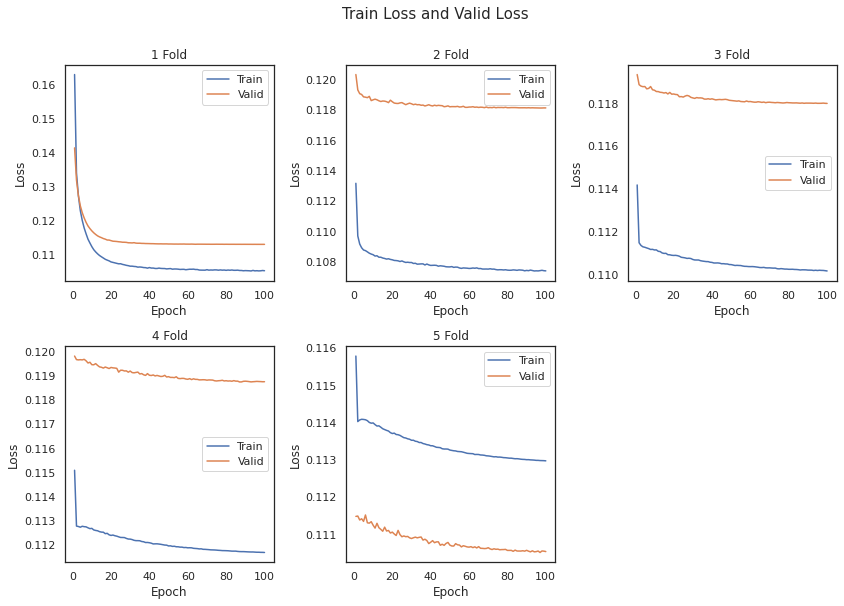

In [120]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

#### Test 예측

In [123]:
flow_scaled_all = np.concatenate([flow_scaled[-nlinear_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=nlinear_args.window)   

In [124]:
preds = predict(model, Xs_test, DEVICE, nlinear_args)

  0%|          | 0/10 [00:00<?, ?it/s]

In [125]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
submission.to_csv(f'./data/submission_city_{nlinear_args.model_name}.csv', index=False)

- 성능 확인

In [126]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

90.21924063543082